In [12]:
import pandas as pd
import numpy as np
import igraph as ig
import os
import pickle
import pycountry
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
from scipy.interpolate import make_interp_spline

In [13]:
with open("./data/graph.pickle", "rb") as f:
    g = pickle.load(f)
    
g.vcount(), g.ecount(), g.is_directed()

(508, 15333, True)

In [14]:
def is_eu(country_name):
    try:
        country = pycountry.countries.lookup(country_name)
        return country.alpha_2 in ('AD', 'AL', 'AM', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BY', 'CH', 'CY', 'CZ', 
                                   'DE', 'DK', 'EE', 'ES', 'FI', 'FO', 'FR', 'GB', 'GE', 'GI', 'GR', 'HR', 
                                   'HU', 'IE', 'IS', 'IT', 'KZ', 'LI', 'LT', 'LU', 'LV', 'MC', 'MD', 'ME', 
                                   'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SI', 'SK', 
                                   'SM', 'TR', 'UA', 'VA')
    except:
        return False

In [15]:
airports_df = pd.read_csv('./data/airports.csv', sep=',', engine='python')
airports_df = airports_df[[is_eu(r['Country']) for _, r in airports_df.iterrows()]]
airports_df = airports_df.reset_index(drop=True)
airports_df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,11,Akureyri Airport,Akureyri,Iceland,AEY,BIAR,65.660004,-18.072701,6,0,N,Atlantic/Reykjavik,airport,OurAirports
1,12,Egilsstaðir Airport,Egilsstadir,Iceland,EGS,BIEG,65.283302,-14.401400,76,0,N,Atlantic/Reykjavik,airport,OurAirports
2,13,Hornafjörður Airport,Hofn,Iceland,HFN,BIHN,64.295601,-15.227200,24,0,N,Atlantic/Reykjavik,airport,OurAirports
3,14,Húsavík Airport,Husavik,Iceland,HZK,BIHU,65.952301,-17.426001,48,0,N,Atlantic/Reykjavik,airport,OurAirports
4,15,Ísafjörður Airport,Isafjordur,Iceland,IFJ,BIIS,66.058098,-23.135300,8,0,N,Atlantic/Reykjavik,airport,OurAirports


In [16]:
lats, lons, sizes = [], [], []
for node in g.vs:
    lats.append(node['lat'])
    lons.append(node['lon'])
    sizes.append(g.degree(node))

C:\Users\janezs\AppData\Local\Temp\ipykernel_44496\539618413.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


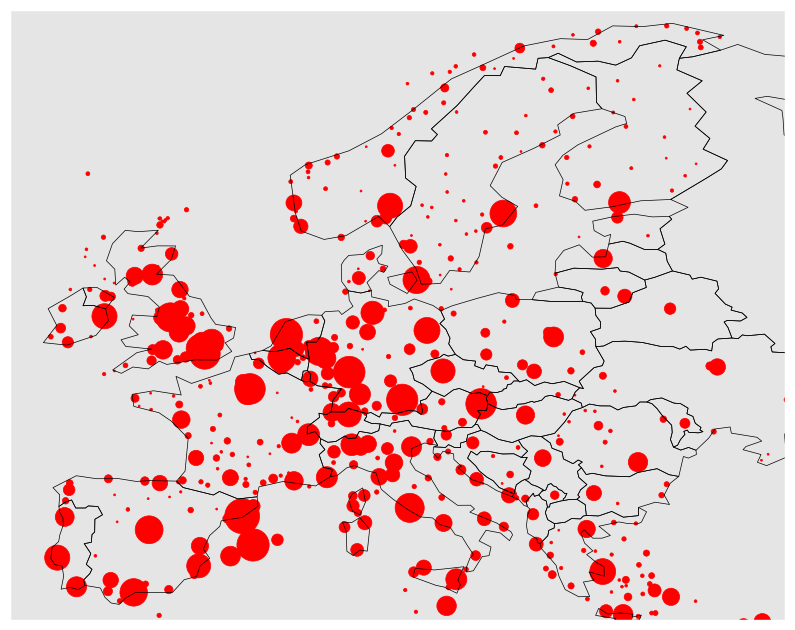

In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world.continent == 'Europe']

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-12, 35, 35, 72], crs=ccrs.PlateCarree())
ax.add_geometries(europe.geometry, crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')
ax.scatter(lons, lats, s=sizes, color='red', transform=ccrs.PlateCarree())
plt.show()

In [18]:
import pandas as pd

def create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Copy the first four columns to a new DataFrame
    new_df = df.iloc[:, :4].copy()
    
    # Initialize a list to store the new 'first_occurrence' column
    first_occurrence = []
    
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        found = False
        # Iterate over the columns, skipping the first four
        for col in df.columns[4:]:
            value = pd.to_numeric(row[col], errors='coerce')
            if not pd.isna(value) and value != 0:
                first_occurrence.append(col)
                found = True
                break
        if not found:
            first_occurrence.append(None)
    
    # Add the new column to the new DataFrame
    new_df['first_occurrence'] = first_occurrence
    
    # Save the new DataFrame to a new CSV file
    new_df.to_csv(output_file_path, index=False)

# Example usage
csv_file_path = './data/time_series_covid19_confirmed_global.csv'
output_file_path = './data/covidAppearance.csv'
create_new_dataframe_with_first_non_zero_column(csv_file_path, output_file_path)

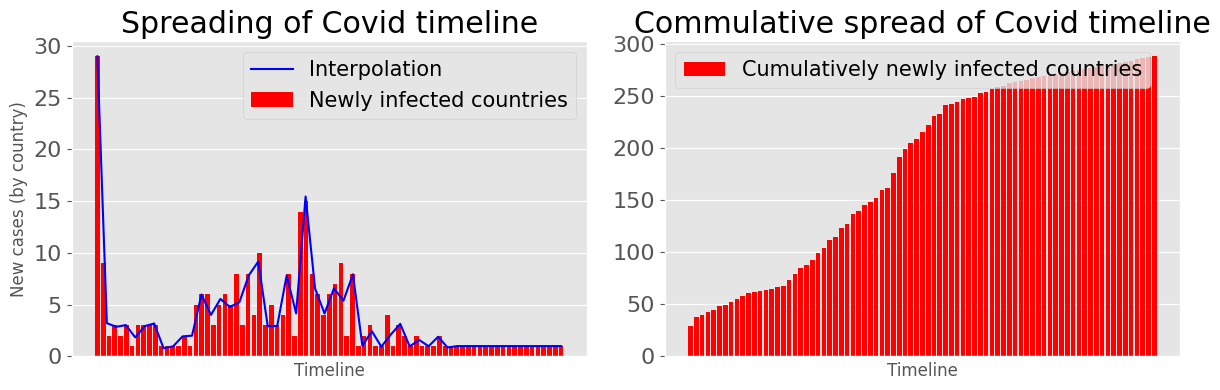

In [41]:
csv_file_path = './data/sortedCovidAppearance.csv'

df = pd.read_csv(csv_file_path)
    
# Convert the 5th column to datetime
df.iloc[:, 4] = pd.to_datetime(df.iloc[:, 4], errors='coerce')

date_counts = df.iloc[:, 4].value_counts().sort_index()
date_counts, len(date_counts)
dates = date_counts.index
counts = date_counts.values
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

x_values = np.linspace(0, len(dates) - 1, 50)
spl = make_interp_spline(np.arange(len(dates)), counts, k=3)
y_values = spl(x_values)

plt.rcParams.update({'font.size': 15})

ax1.bar(np.arange(len(dates)), counts, color='red', label="Newly infected countries")
ax1.plot(x_values, y_values, color='blue', linestyle='-', label='Interpolation')
ax1.set_title('Spreading of Covid timeline')
ax1.set_xlabel('Timeline')
ax1.set_ylabel('New cases (by country)')
ax1.set_xticks([])
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.grid(True)
ax1.legend()

commulative_counts = np.array(counts).copy()
for i in range(1, len(commulative_counts)):
    commulative_counts[i] += commulative_counts[i - 1]

ax2.bar(np.arange(len(dates)), commulative_counts, color='red', label='Cumulatively newly infected countries')
ax2.set_title('Commulative spread of Covid timeline')
ax2.set_xlabel('Timeline')
ax2.set_xticks([])
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.grid(True)
ax2.legend()

plt.style.use('ggplot')
plt.tight_layout()
plt.show()